In [1]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 

# Loading Data

In [2]:
# fetch dataset 

from ucimlrepo import fetch_ucirepo 
  
auto_mpg = fetch_ucirepo(id=9) 
  
auto_mpg['metadata']['data_url']

'https://archive.ics.uci.edu/static/public/9/data.csv'

In [3]:
url = 'https://archive.ics.uci.edu/static/public/9/data.csv'
df = pd.read_csv(url)
df.head()

,car_name,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg
0,"chevrolet,chevelle,malibu",8,307.0,130.0,3504,12.0,70,1,18.0
1,"buick,skylark,320",8,350.0,165.0,3693,11.5,70,1,15.0
2,"plymouth,satellite",8,318.0,150.0,3436,11.0,70,1,18.0
3,"amc,rebel,sst",8,304.0,150.0,3433,12.0,70,1,16.0
4,"ford,torino",8,302.0,140.0,3449,10.5,70,1,17.0


# Data Preprocessing

In [4]:
# Understanding the df
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   car_name      398 non-null    object 
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   mpg           398 non-null    float64
dtypes: float64(4), int64(4), object(1)
memory usage: 28.1+ KB
None


In [5]:
df['make'] = df['car_name'].str.split(',', 1).str[0]
df = df.drop(columns=['car_name'])
df.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg,make
0,8,307.0,130.0,3504,12.0,70,1,18.0,chevrolet
1,8,350.0,165.0,3693,11.5,70,1,15.0,buick
2,8,318.0,150.0,3436,11.0,70,1,18.0,plymouth
3,8,304.0,150.0,3433,12.0,70,1,16.0,amc
4,8,302.0,140.0,3449,10.5,70,1,17.0,ford


In [6]:
# Missing Value Check
print(df.isnull().sum())
df.dropna(inplace=True) #dropping because only one 6 rows were missing

cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
mpg             0
make            0
dtype: int64


In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
#transforming categorical values
df['make'] = label_encoder.fit_transform(df['make'])

df.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg,make
0,8,307.0,130.0,3504,12.0,70,1,18.0,7
1,8,350.0,165.0,3693,11.5,70,1,15.0,3
2,8,318.0,150.0,3436,11.0,70,1,18.0,25
3,8,304.0,150.0,3433,12.0,70,1,16.0,0
4,8,302.0,140.0,3449,10.5,70,1,17.0,13


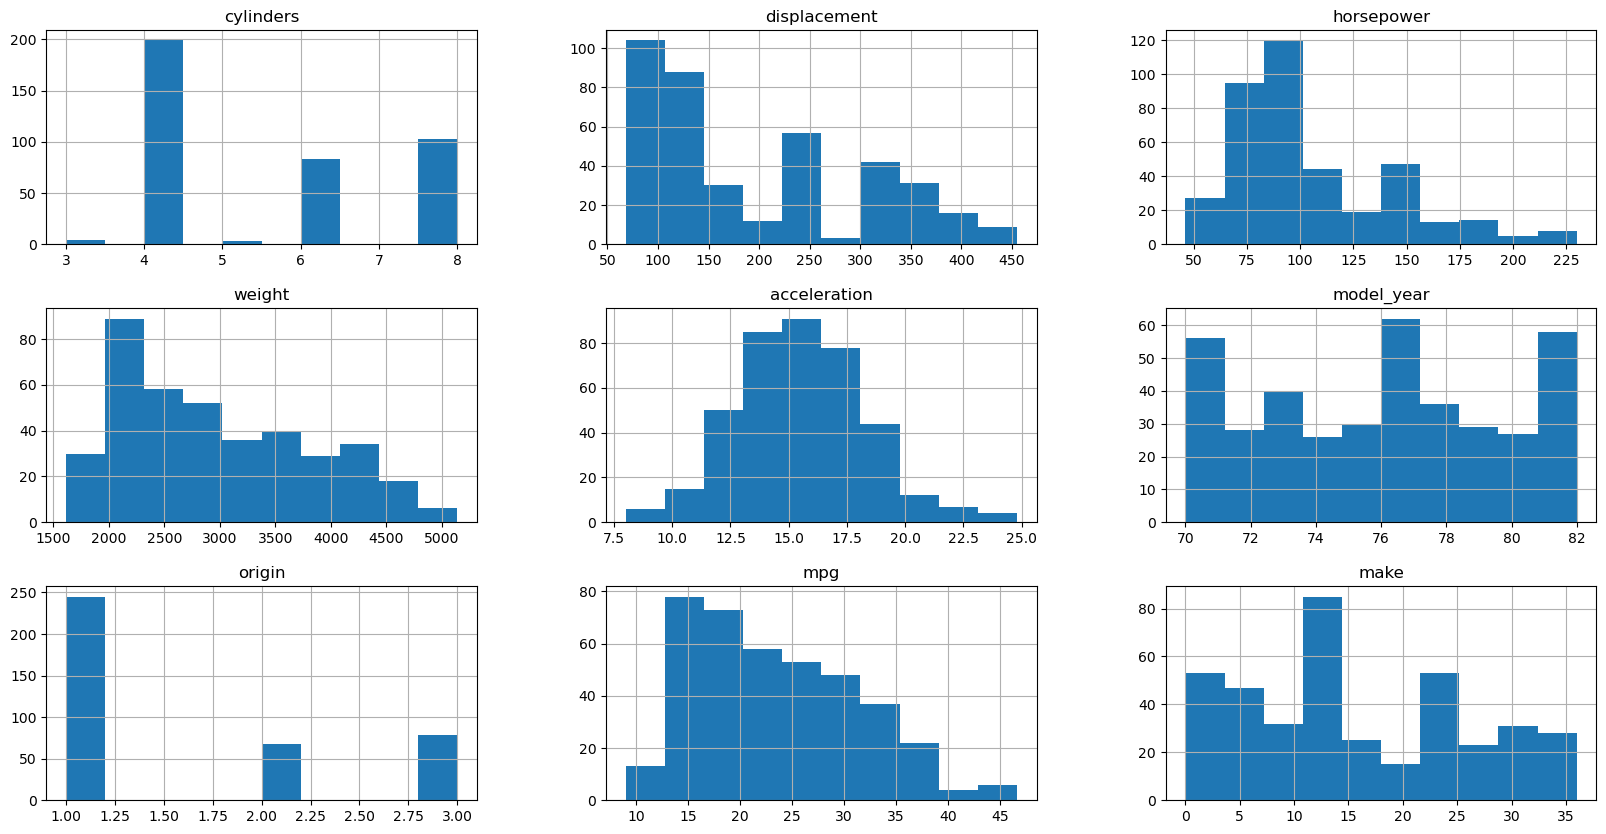

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of attributes
df.hist(figsize=(20, 10))
plt.show()

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X = df.drop('mpg', axis=1)
y = df['mpg']

# Standardize features
standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X)

df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
df_scaled['mpg'] = y.reset_index(drop=True)

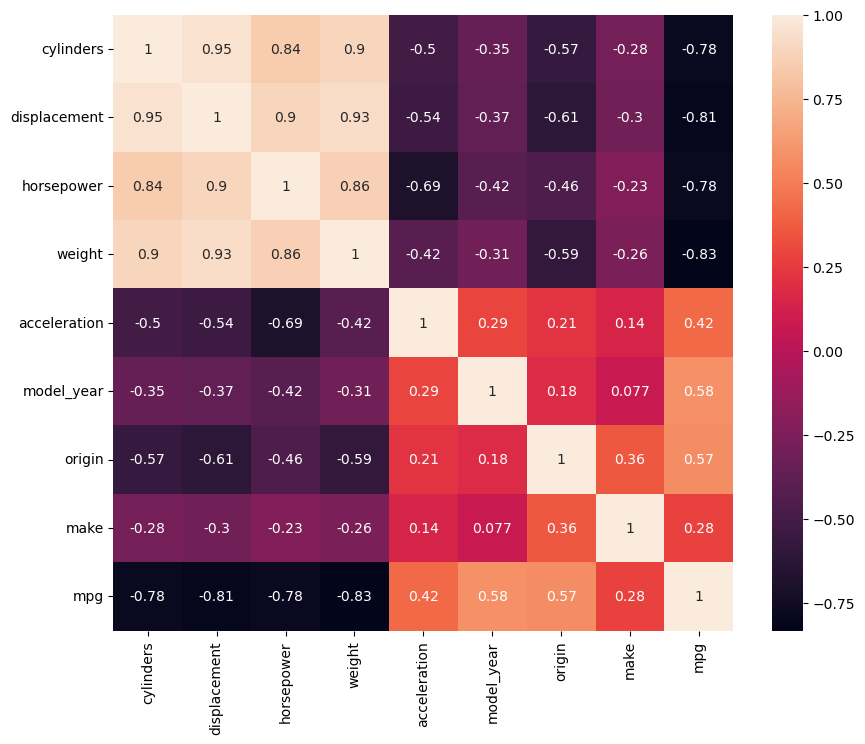

In [10]:
# Correlation matrix to understand correlation between fires and other variables
correlation_matrix = df_scaled.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [11]:
features = ['cylinders','displacement','horsepower','weight','acceleration','model_year','origin', 'make'] 
#abs value > .25 is what I used to determine if I wwanted to include it

In [12]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score


X = df_scaled[features]
y = df_scaled['mpg']

# Splitting and training the data. I chose 80/20 split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Model Construction

In [13]:
from sklearn.model_selection import GridSearchCV
sgd = SGDRegressor()

#parameter grid
param_grid = {
    'loss': ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty': [None, 'l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.01, 0.1, 0.5],
    'max_iter': [1000, 2000, 3000, 5000]
}
#GridSearchCV
grid_search = GridSearchCV(sgd, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters and estimator
best_params = grid_search.best_params_
best_sgd = grid_search.best_estimator_

Fitting 5 folds for each of 3840 candidates, totalling 19200 fits


In [14]:
# Predicting based on the tuned hyperparameters
y_train_pred = best_sgd.predict(X_train)
y_test_pred = best_sgd.predict(X_test)

# metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Adjusted R^2 calculation
n_train, p_train = X_train.shape
n_test, p_test = X_test.shape
train_adj_r2 = 1 - (1 - train_r2) * (n_train - 1) / (n_train - p_train - 1)
test_adj_r2 = 1 - (1 - test_r2) * (n_test - 1) / (n_test - p_test - 1)

# variance calculation
cv_scores = cross_val_score(sgd, X, y, cv=5, scoring='neg_mean_squared_error')
mse_scores = -cv_scores
mean_mse = np.mean(mse_scores)
variance_mse = np.var(mse_scores)
print(f"Variance: {variance_mse}")

print(f"Training MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Training R^2: {train_r2}")
print(f"Test R^2: {test_r2}")
print(f"Training Adjusted R^2: {train_adj_r2}")
print(f"Test Adjusted R^2: {test_adj_r2}")

Variance: 61.80481352679949
Training MSE: 9.581574448241023
Test MSE: 16.922066581683097
Training R^2: 0.8281489759500529
Test R^2: 0.7723675585334094
Training Adjusted R^2: 0.8236265805803175
Test Adjusted R^2: 0.7463524223657991


In [15]:
import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

In [16]:
# fitting the model 
ols_model = sm.OLS(y_train, X_train_sm).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     187.8
Date:                Sun, 08 Sep 2024   Prob (F-statistic):          8.02e-113
Time:                        17:26:35   Log-Likelihood:                -794.51
No. Observations:                 313   AIC:                             1607.
Df Residuals:                     304   BIC:                             1641.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           23.1806      0.176    131.663   